# Align, Xmatch and PSF Photometry

Some useful resources:

https://quatrope.github.io/astroalign/
https://astroalign.readthedocs.io/en/latest/index.html

https://dlnpyutils.readthedocs.io/en/latest/

https://theprometheus.readthedocs.io/en/latest/

Packages you need to pip install:
* astroalign
* dlnpyutils
* prometheus

Files you will need:
* gaia.fits
* tmass.fits
* nsc.fits
* image.fits

In [49]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
import astroalign as aa
from dlnpyutils import coords
import prometheus
%matplotlib inline

## Astroalign

First, let's make some fake images

In [2]:
h, w = img_shape = (200, 200)
n_stars = 10
pos_x = np.random.randint(10, w - 10, n_stars)
pos_y = np.random.randint(10, h - 10, n_stars)
fluxes = 200.0 + np.random.rand(n_stars) * 300.0
img_posxy = np.array([[x, y] for x, y in zip(pos_x, pos_y)], dtype="float64")

img = np.zeros(img_shape)
for x, y, f in zip(pos_x, pos_y, fluxes):
    img[y, x] = f

# Let's rotate and expand the original image
from scipy.ndimage import rotate, zoom
img_rotated = rotate(img, angle=30.0, reshape=False)
img_rotated = zoom(img_rotated, 1.5, order=2)

# Let's add a Gaussian PSF response with different seeing for both images
from scipy.ndimage.filters import gaussian_filter
img = gaussian_filter(img, sigma=2.0, mode='constant')
img_rotated = gaussian_filter(img_rotated, sigma=1.5, mode='constant')

# Let's add some noise to the images
noise_dc = 5.0
noise_std = np.sqrt(noise_dc)
img += np.random.normal(loc=noise_dc, scale=noise_std, size=img.shape)
img_rotated += np.random.normal(loc=noise_dc, scale=noise_std, size=img_rotated.shape)

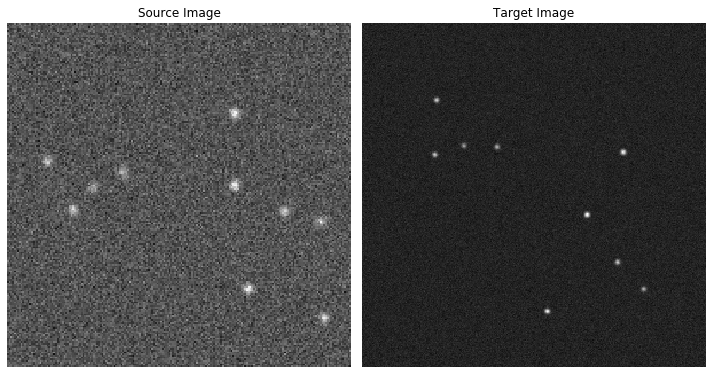

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img, cmap='gray', interpolation='none', origin='lower')
axes[0].axis('off')
axes[0].set_title("Source Image")

axes[1].imshow(img_rotated, cmap='gray', interpolation='none', origin='lower')
axes[1].axis('off')
axes[1].set_title("Target Image")
plt.tight_layout()


Now let's figuring out the transformation

In [9]:
img_aligned, footprint = aa.register(img, img_rotated, detection_sigma=3.0)

In [10]:
p, (pos_img, pos_img_rot) = aa.find_transform(img_posxy, img_rotated)

In [11]:
print("Rotation: {:.2f} degrees".format(p.rotation * 180.0 / np.pi))
print("\nScale factor: {:.2f}".format(p.scale))
print("\nTranslation: (x, y) = ({:.2f}, {:.2f})".format(*p.translation))
print("\nTranformation matrix:\n{}".format(p.params))
print("\nPoint correspondence:")
for (x1, y1), (x2, y2) in zip(pos_img, pos_img_rot):
    print("({:.2f}, {:.2f}) is source --> ({:.2f}, {:.2f}) in target"
          .format(x1, y1, x2, y2))

Rotation: -30.00 degrees

Scale factor: 1.50

Translation: (x, y) = (-54.74, 94.77)

Tranformation matrix:
[[  1.30140523   0.75128688 -54.73666331]
 [ -0.75128688   1.30140523  94.77366424]
 [  0.           0.           1.        ]]

Point correspondence:
(182.00, 84.00) is source --> (245.25, 67.34) in target
(132.00, 147.00) is source --> (227.47, 186.79) in target
(161.00, 90.00) is source --> (222.47, 90.95) in target
(38.00, 91.00) is source --> (63.08, 184.73) in target
(50.00, 104.00) is source --> (88.49, 192.52) in target
(23.00, 119.00) is source --> (64.59, 232.34) in target
(67.00, 113.00) is source --> (117.31, 191.51) in target
(140.00, 45.00) is source --> (161.30, 48.18) in target
(132.00, 105.00) is source --> (195.91, 132.30) in target


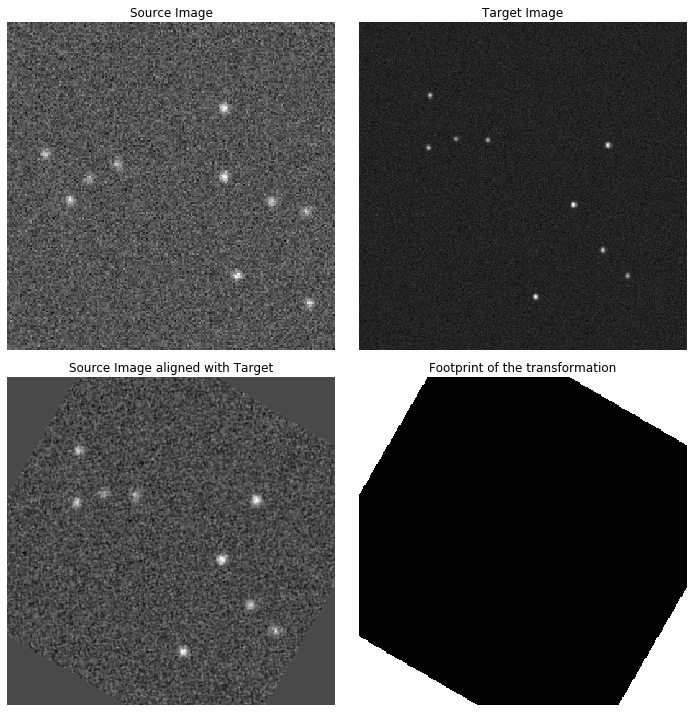

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(img, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")

axes[0, 1].imshow(img_rotated, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")

axes[1, 0].imshow(img_aligned, cmap='gray', interpolation='none', origin='lower')
axes[1, 0].axis('off')
axes[1, 0].set_title("Source Image aligned with Target")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Footprint of the transformation")

axes[1, 0].axis('off')

plt.tight_layout()

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Create another fake image using the methods above (with ``rotate``, ``zoom``)
    
2) Use ``astroalign`` to align the images.
    
3) Make a 3-panel plot comparing the images.

</font>

## Crossmatching
Crossmatching is to match up stars that are in two different lists/catlaogs and the coordinates are correct (or close).

I've downloaded a table of stars in the Gaia EDR3 catalog and in the 2MASS catalog in the same region of the sky.  Let's match them up.

In [91]:
gaia = Table.read('gaia.fits')
print(len(gaia),' gaia sources')

1683  gaia sources


In [92]:
tmass = Table.read('tmass.fits')
print(len(tmass),' tmass sources')

735  tmass sources


Let's plot them up

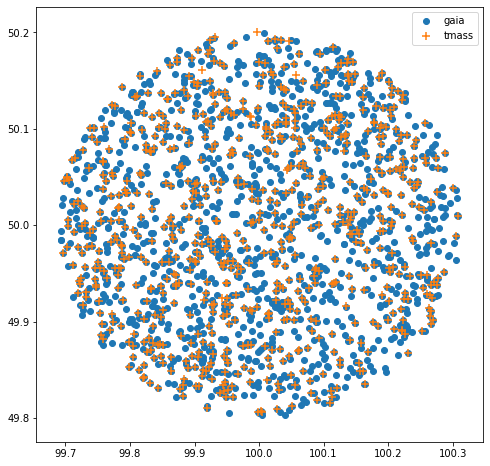

In [112]:
fig = plt.figure(figsize=(8,8))
plt.scatter(gaia['ra'],gaia['dec'],marker='o',label='gaia')
plt.scatter(tmass['ra'],tmass['dec'],marker='+',s=50,label='tmass')
plt.legend()

We can see that many sources are detected in both catalogs, but not all of them.  Let's find those in both.

You need to give the ``xmatch`` function two sets of coordinates and the crossmatch radius (in arcsec).

``ind1,ind2,dist = coords.xmatch(ra1,dec1,ra2,dec2,1.0)``

It returns information for the matches: (1) the indices into the first catalog, (2) the indices into the second catalog, and (3) the distances between the two points.

In [103]:
ind1,ind2,dist = coords.xmatch(gaia['ra'],gaia['dec'],tmass['ra'],tmass['dec'],1.0)
print(len(ind1), 'matches')

735 matches


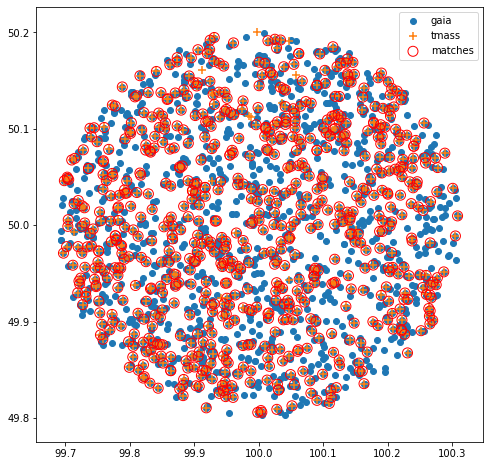

In [111]:
fig = plt.figure(figsize=(8,8))
plt.scatter(gaia['ra'],gaia['dec'],marker='o',label='gaia')
plt.scatter(tmass['ra'],tmass['dec'],marker='+',s=50,label='tmass')
plt.scatter(tmass['ra'][ind2],tmass['dec'][ind2],marker='o',facecolors='none',edgecolors='r',s=100,label='matches')
plt.legend()

In [113]:
# It's often useful to create "matched" catalogs
gaia_match = gaia[ind1]
tmass_match = tmass[ind2]

Text(0.5, 1.0, 'Gaia and 2MASS Color Magnitude Diagram')

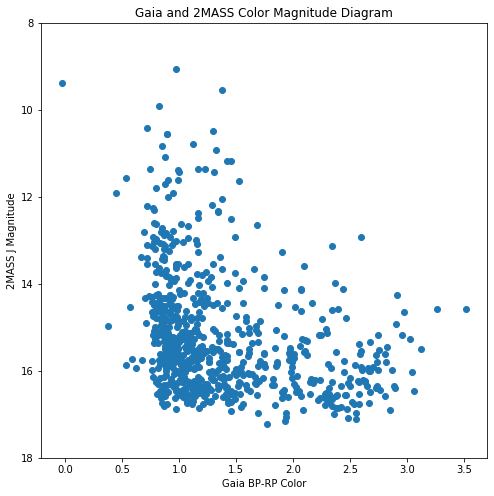

In [120]:
# Now you can use information from *both* catalogs directly
fig = plt.figure(figsize=(8,8))
plt.scatter(gaia_match['bp_rp'],tmass_match['j_m'])
plt.xlabel('Gaia BP-RP Color')
plt.ylabel('2MASS J Magnitude')
plt.ylim(18,8)
plt.title('Gaia and 2MASS Color Magnitude Diagram')

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Now match the Gaia and NSC ("nsc.fits') catalogs.
    
2) Match the matched catalogs and make a CMD with ``bp_rp`` from Gaia and ``rmag`` from NSC.

</font>

# PSF Photometry with Prometheus

In [19]:
from prometheus import ccddata,prometheus,models
from prometheus.ccddata import CCDData

In [20]:
image = CCDData.read('image.fits')

In [24]:
image

CCDData([[6690.645 , 6649.7256, 6629.9736, ..., 6607.448 , 6654.932 ,
          6709.3467],
         [6553.6343, 6662.985 , 6645.0073, ..., 6664.3984, 6624.5225,
          6599.72  ],
         [6638.526 , 6616.5605, 6697.084 , ..., 6582.6406, 6682.436 ,
          6772.4287],
         ...,
         [6764.22  , 6710.4526, 6666.8896, ..., 6575.875 , 6663.582 ,
          6666.895 ],
         [6772.0825, 6583.253 , 6678.261 , ..., 6584.5234, 6688.158 ,
          6687.9243],
         [6672.346 , 6655.838 , 6615.8877, ..., 6662.5093, 6608.6963,
          6757.5405]])
BoundingBox(ixmin=0, ixmax=500, iymin=0, iymax=500)

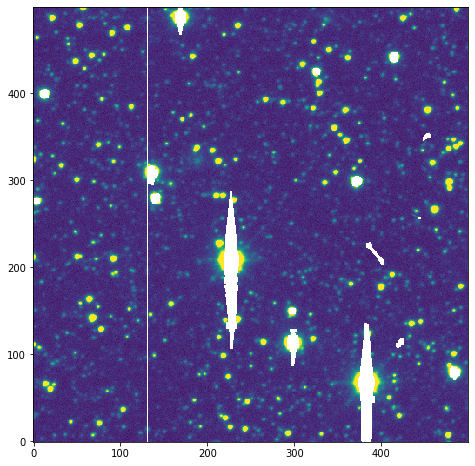

In [23]:
fig = plt.figure(figsize=(8,8))
plt.imshow(image,origin='lower',vmax=8000)

## Construct an initial PSF model

In [29]:
# input parameters are [sigma_x,sigma_y,theta]
psf = models.PSFGaussian([3.5,4.5,1.0])

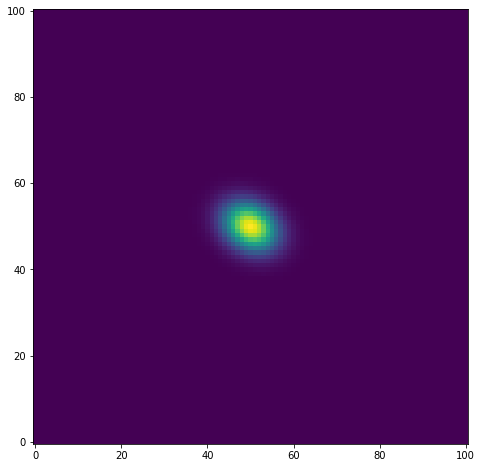

In [30]:
# Plot up the PSF image
fig = plt.figure(figsize=(8,8))
plt.imshow(psf(),origin='lower')

## let's fit a single star

(0, 60)

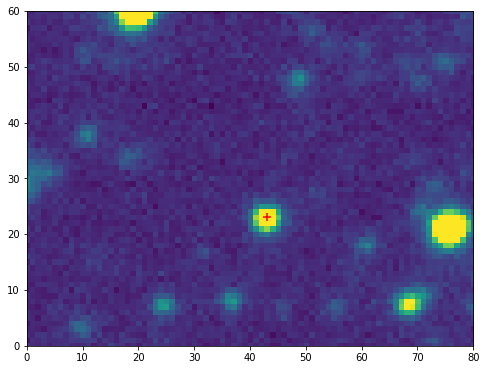

In [41]:
fig = plt.figure(figsize=(8,8))
plt.imshow(image,origin='lower',vmax=8000)
plt.scatter([43],[23],c='r',marker='+',s=50)
plt.xlim(0,80)
plt.ylim(0,60)

## We can easily do this by using the ``psf.fit()`` method.

In [46]:
out,model = psf.fit(image,[100,43,23])

In [50]:
Table(out)

id,height,height_error,x,x_error,y,y_error,sky,sky_error,flux,flux_error,mag,mag_error,niter,nfitpix,rms,chisq
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1,695.9585281162298,54.88627270966936,43.00190797388927,0.3471755697452482,22.826772327588024,0.3127652470702214,6572.243219667995,17.80958889223734,6828.571088244419,538.5303862590985,15.41417541261701,0.08562581104712583,2,441,0.32018197754420347,522.7828969101922


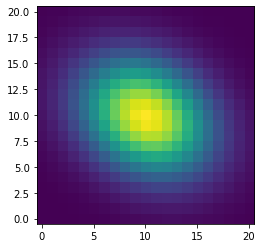

In [52]:
plt.imshow(model,origin='lower')

## Let's fit the PSF to a number of isolated stars

In [55]:
from prometheus import detection,aperture,utils
# Initial source detection
objects = detection.detect(image)
# Measure aperture photometry (not totally necessary)
objects = aperture.aperphot(image,objects)
# Estiomate the FWHM using the morphology parameters
fwhm = utils.estimatefwhm(objects,verbose=True)
# Pick good, isolated stars to fit the PSF
psfobj = utils.pickpsfstars(objects,fwhm,verbose=True)

FWHM =  4.15 pixels (99 sources)
Too few PSF stars on first try. Loosening cuts
62 PSF stars found


In [65]:
# Now we construct an initial PSF model, and run ``getpsf``
from prometheus import getpsf
initpsf=models.psfmodel('gaussian',[fwhm/2.35,0.9*fwhm/2.35,0.0],binned=False)
newpsf,pars,perror,psfcat = getpsf.getpsf(initpsf,image,psfobj,verbose=True) 

Removing 3 stars near the edge
--- Iteration 1 ---
  Fitting radius = 4.020
  pars =  [1.76587692 1.58928923 0.        ]
  dbeta =  [-0.04664178  0.00308488  0.17500937]
   2 [1.71923515 1.59237411 0.17500937] 17.500937465352713 76660.35969362037
  pars =  [1.71923515 1.59237411 0.17500937]
  dbeta =  [-0.0050739  -0.01728572  0.06062299]
   3 [1.71416124 1.57508839 0.23563237] 34.639854619146455 68061.0814144465
  pars =  [1.71416124 1.57508839 0.23563237]
  dbeta =  [-0.00500747 -0.00571915 -0.00476917]
   4 [1.70915377 1.56936925 0.23086319] 2.0239888879559134 65152.11345100626
  pars =  [1.70915377 1.56936925 0.23086319]
  dbeta =  [-0.00286962 -0.00266028 -0.00031499]
   5 [1.70628415 1.56670897 0.2305482 ] 0.16951274937694816 63909.46684613564
Best-fitting parameters:  [1.70628415 1.56670897 0.2305482 ]
Errors:  [0.005287   0.00471933 0.0291575 ]
Median RMS:  0.07209504624967418
dt = 0.43 sec
dt = 0.44 sec


## Now let's fit that star again

In [66]:
out2,model2 = newpsf.fit(image,[100,43,23])

In [67]:
Table(out2)

id,height,height_error,x,x_error,y,y_error,sky,sky_error,flux,flux_error,mag,mag_error,niter,nfitpix,rms,chisq
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1,2218.101548596866,45.89319964113569,42.89566652184136,0.037360909199378095,22.79893771151233,0.03456596741835497,6646.292396892122,13.728529159916022,8669.303270645561,179.37053693550155,15.155039510598026,0.02246421424397549,2,81,0.04460670781273369,45.28151805050342


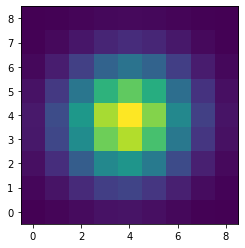

In [122]:
plt.imshow(model2,origin='lower')

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Pick a star in the image and determine its central coordinates.
    
2) Fit the PSF to it using ``psf.fit()``.
 
3) Plot the star in the original image (zoom in), and the model, side-by-side.

</font>

## Run all steps

In [78]:
from prometheus import prometheus
out,model,sky,psf = prometheus.run(image,'gaussian',verbose=True)

Step 1: Detection
1102 objects detected
Step 2: Aperture photometry
Min/Max mag: 10.93, 17.51
Step 3: Estimate FWHM
FWHM =  4.15 pixels (99 sources)
Step 3: Pick PSF stars
Too few PSF stars on first try. Loosening cuts
62 PSF stars found
Step 4: Construct PSF
Final PSF: PSFGaussian([1.7062841474631407, 1.5667089657524924, 0.23054820186176364],binned=False)
Median RMS:  0.0721
Step 5: Get PSF photometry for all objects
dt =  7.395678997039795


Text(0.5, 1.0, 'Residuals')

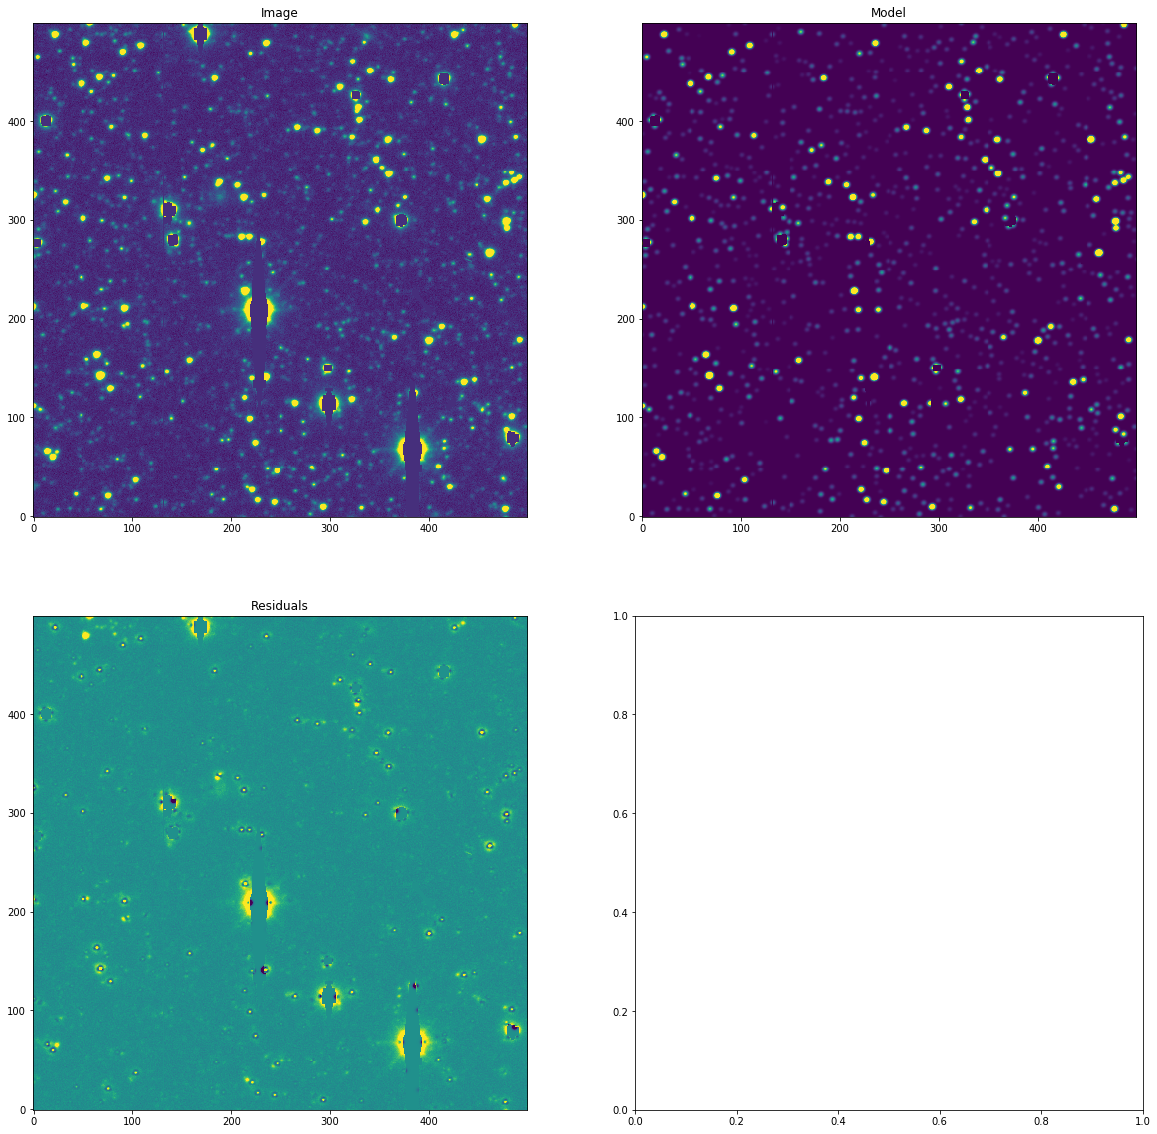

In [87]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))
axes[0,0].imshow(image.data, interpolation='none', origin='lower',vmax=8000)
axes[0,0].set_title("Image")
axes[0,1].imshow(model.data, interpolation='none', origin='lower',vmax=2000)
axes[0,1].set_title("Model")
axes[1,0].imshow(image.data-image.sky-model.data, interpolation='none', origin='lower',vmin=-1000,vmax=1000)
axes[1,0].set_title("Residuals")

### If we zoom in we can see that the PSF is not fitting well in the very center and in the wings

(0, 100)

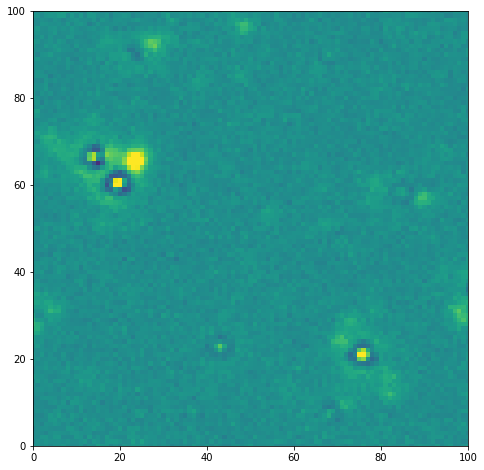

In [123]:
fig = plt.figure(figsize=(8,8))
plt.imshow(image.data-image.sky-model.data, interpolation='none', origin='lower',vmin=-1000,vmax=1000)
plt.xlim(0,100)
plt.ylim(0,100)

## We can improve the fit by using a Penny function which fits the wings better

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Run ``prometheus.run()`` again with ``penny``.

2) Remake the 3-panel plot and see if the fit is better.
</font>